<a href="https://colab.research.google.com/github/cyrus2281/notes/blob/main/MachineLearning/PyTorch/LazyProgrammer/02_PyTorch_Advanced_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

>[Content](#scrollTo=KK6FzBGvITph)

>[Natural Language Processing](#scrollTo=PViL3CNyIerk)

>>[Text Preprocessing](#scrollTo=5kATizpXOkEX)

>>[Text Classification](#scrollTo=mIwD1WwCR7lz)

>[Transfer Learning](#scrollTo=Kbf4QccJUIR-)

>[Generative Adversarial Network](#scrollTo=xPVoa20s_jGM)

>[New Section](#scrollTo=pdwCUvgWitrt)



# Natural Language Processing

## Text Preprocessing

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Let's make some fake data!
data = {
    "label": [0, 1, 1],
    "data":[
        "I like eggs and ham.",
        "Eggs I like!",
        "Ham and eggs or just ham?",
    ]
}

In [ ]:
df = pd.DataFrame(data)
df.head()

,label,data
0,0,I like eggs and ham.
1,1,Eggs I like!
2,1,Ham and eggs or just ham?


In [ ]:
df.to_csv('thedata.csv', index=False)

In [ ]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=True,
    pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the dataset
# it will be like: for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path='thedata.csv',
    format='csv',
    skip_header=True,
    fields=[('label', LABEL), ('data', TEXT)]
)

In [ ]:
ex = dataset.examples[0]

In [ ]:
type(ex), ex.data, ex.label

(torchtext.data.example.Example, ['i', 'like', 'eggs', 'and', 'ham.'], '0')

In [ ]:
train_dataset, test_dataset = dataset.split(0.66) # default is 0.7

In [ ]:
TEXT.build_vocab(train_dataset,)

In [ ]:
vocab = TEXT.vocab
type(vocab)

torchtext.vocab.Vocab

In [ ]:
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7e08de40b0a0>>,
            {'<unk>': 0,
             '<pad>': 1,
             'eggs': 2,
             'and': 3,
             'ham': 4,
             'ham?': 5,
             'i': 6,
             'just': 7,
             'like!': 8,
             'or': 9})

In [ ]:
vocab.itos

['<unk>', '<pad>', 'eggs', 'and', 'ham', 'ham?', 'i', 'just', 'like!', 'or']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key=lambda x : len(x.data),
    batch_sizes=(2,2), device=device)

In [ ]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shpape:", targets.shape)

inputs: tensor([[1, 1, 1, 2, 6, 8],
        [4, 3, 2, 9, 7, 5]], device='cuda:0') shape: torch.Size([2, 6])
targets: tensor([1, 1], device='cuda:0') shpape: torch.Size([2])


In [ ]:
for inputs, targets in test_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shpape:", targets.shape)

inputs: tensor([[6, 0, 2, 3, 0]], device='cuda:0') shape: torch.Size([1, 5])
targets: tensor([0], device='cuda:0') shpape: torch.Size([1])


## Text Classification

In [ ]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-12-31 05:10:57--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.30MB/s    in 0.4s    

2023-12-31 05:10:59 (1.30 MB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename columns to something better
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

df2 = df[['data', 'b_labels']]

df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df2.to_csv('spam2.csv', index=False)

In [ ]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [ ]:
train_dataset, test_dataset = dataset.split() # default is 0.7

In [ ]:
TEXT.build_vocab(train_dataset,)

In [ ]:
vocab = TEXT.vocab

vocab.itos[:5], vocab.stoi['you']

(['<unk>', '<pad>', 'to', 'you', 'I'], 3)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_iter, test_iter = ttd.Iterator.splits(
        (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
        batch_sizes=(32, 256), device=device)

In [ ]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[    1,     1,     1,  ..., 12288,  2521,  2981],
        [    1,     1,     1,  ...,     4,    31,    44],
        [    1,     1,     1,  ...,   103,   675,   197],
        ...,
        [    1,     1,     1,  ...,   293,   562,  4851],
        [    4,  1160,   101,  ...,    14,   387,  1074],
        [    1,     1,     1,  ...,     3,   452,  1705]], device='cuda:0') shape: torch.Size([32, 36])
targets: tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0') shape: torch.Size([32])


In [ ]:
for inputs, targets in test_iter:
  print("inputs:", inputs)
  print("targets:", targets)
  break

inputs: tensor([[  201,    68,    23,   138,     8,   385],
        [ 2351,    36,     0,    29,    51,   623],
        [  263,   107,    74,    43,  2869, 10142],
        ...,
        [    1,     1,     1,     1,     1,  6738],
        [    1,     1,     1,     1,     1,     0],
        [    1,     1,     1,     1,     1,   129]], device='cuda:0')
targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [ ]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    # max pool
    out, _ = torch.max(out, 1)

    # we only want h(T) at the final time step
    out = self.fc(out)
    return out

In [ ]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(12402, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 15)

Epoch 1/15, Train Loss: 0.4723,       Test Loss: 0.4185, Duration: 0:00:01.765047
Epoch 2/15, Train Loss: 0.3636,       Test Loss: 0.4095, Duration: 0:00:00.370674
Epoch 3/15, Train Loss: 0.3015,       Test Loss: 0.3722, Duration: 0:00:00.383863
Epoch 4/15, Train Loss: 0.2161,       Test Loss: 0.3498, Duration: 0:00:00.390218
Epoch 5/15, Train Loss: 0.1595,       Test Loss: 0.3124, Duration: 0:00:00.386197
Epoch 6/15, Train Loss: 0.1158,       Test Loss: 0.2723, Duration: 0:00:00.377194
Epoch 7/15, Train Loss: 0.0895,       Test Loss: 0.2532, Duration: 0:00:00.396085
Epoch 8/15, Train Loss: 0.0707,       Test Loss: 0.2245, Duration: 0:00:00.374977
Epoch 9/15, Train Loss: 0.0578,       Test Loss: 0.1987, Duration: 0:00:00.402898
Epoch 10/15, Train Loss: 0.0496,       Test Loss: 0.2030, Duration: 0:00:00.383157
Epoch 11/15, Train Loss: 0.0399,       Test Loss: 0.2251, Duration: 0:00:00.386496
Epoch 12/15, Train Loss: 0.0351,       Test Loss: 0.1894, Duration: 0:00:00.382659
Epoch 13/15, 

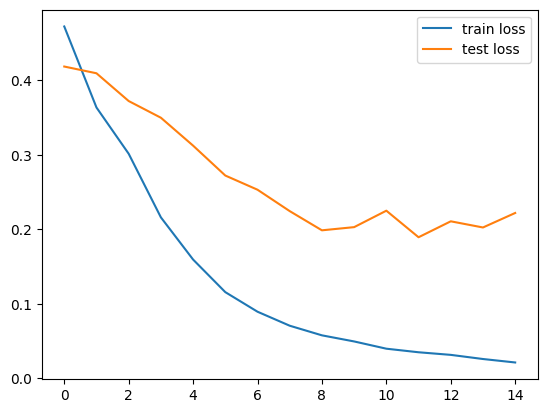

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9972, Test acc: 0.9091


# Transfer Learning

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio

In [ ]:
# Data from : https://mmspg.epfl.ch/downloads/food-image-datasets/
!wget --passive-ftp --prefer-family=ipv4 --ftp-user datasets@mmspgdata.epfl.ch \
 --ftp-password ohsh9jah4T -nc ftp://tremplin.epfl.ch/FoodImage/Food-5K.zip

--2024-01-03 06:12:41--  ftp://tremplin.epfl.ch/FoodImage/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.218.41, 2001:620:618:1da:7:80b2:da01:3
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.218.41|:21... connected.
Logging in as datasets@mmspgdata.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /FoodImage ... done.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M  19.1MB/s    in 24s     

2024-01-03 06:13:23 (18.0 MB/s) - ‘Food-5K.zip’ saved [446919921]



In [ ]:
!unzip -qq -o Food-5K.zip

In [ ]:
# Make dir to store the data Keras-style
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food
# Move the images
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [ ]:
# Note: normalize mean and std are standardized for ImageNet
# https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173

train_transform = transforms.Compose([
  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(),
  transforms.CenterCrop(size=224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
  transforms.Resize(size=256),
  transforms.CenterCrop (size=224),
  transforms. ToTensor (),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets. ImageFolder(
  'data/train',
  transform=train_transform
)

test_dataset=datasets.ImageFolder(
  'data/test',
  transform=test_transform
)

In [ ]:
batch_size = 128
train_loader=torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size,
)

In [ ]:
# Define the model
model = models.vgg16(weights=True)

# Freeze VGG weights
for param in model.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# we want to replace the `classifier`
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
n_features = model.classifier[0].in_features
n_features

25088

In [ ]:
# We're doing binary classification
model.classifier = nn.Linear(n_features, 2)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(
  model,
  criterion,
  optimizer,
  train_loader,
  test_loader,
  epochs=5,
)


Epoch 1/5, Train Loss: 0.1521,       Test Loss: 0.0882, Duration: 0:00:47.399200
Epoch 2/5, Train Loss: 0.0734,       Test Loss: 0.1030, Duration: 0:00:46.743272
Epoch 3/5, Train Loss: 0.0285,       Test Loss: 0.0975, Duration: 0:00:47.405610
Epoch 4/5, Train Loss: 0.0165,       Test Loss: 0.0700, Duration: 0:00:48.645385
Epoch 5/5, Train Loss: 0.0143,       Test Loss: 0.0923, Duration: 0:00:47.083802


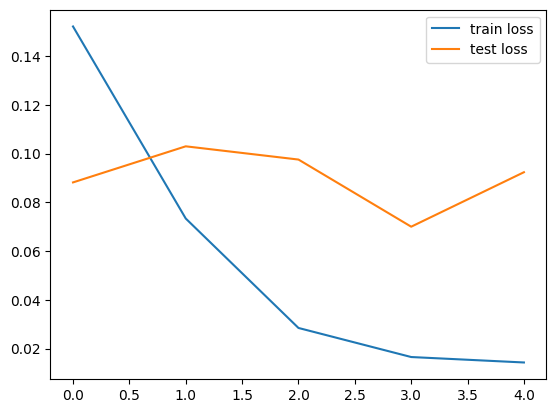

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# Generative Adversarial Network

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
train_dataset = torchvision.datasets.MNIST(
  root='.',
  train=True,
  transform=transform,
  download=True
)

In [6]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True
)

In [7]:
# Discriminator
D = nn.Sequential(
  nn.Linear(784, 512),
  nn.LeakyReLU(0.2),
  nn.Linear(512, 256),
  nn.LeakyReLU(0.2),
  nn.Linear(256, 1),
  #nn.Sigmoid()
)


# Generator
latent_dim = 100
G = nn.Sequential(
  nn.Linear(latent_dim, 256),
  nn.LeakyReLU(0.2),
  nn.BatchNorm1d(256, momentum=0.7),
  nn.Linear(256, 512),
  nn.LeakyReLU(0.2),
  nn.BatchNorm1d(512, momentum=0.7),
  nn.Linear(512, 1024),
  nn.LeakyReLU (0.2),
  nn.BatchNorm1d(1024, momentum=0.7),
  nn.Linear(1024, 784),
  nn.Tanh()
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
D = D.to(device)
G = G.to(device)

cuda:0


In [12]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [11]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img+1)/2
  return out

In [16]:
# Training Loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(50):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    ### Train Discriminator

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### Train Generator
    # do it twice
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save lossess
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  # print and save
  print(f"Epoch: {epoch}, d_loss: {d_losses[-1]}, g_loss: {g_losses[-1]}")

  # PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1,1,28,28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 21, d_loss: 0.6647630929946899, g_loss: 0.6473058462142944
Epoch: 22, d_loss: 0.6691431999206543, g_loss: 0.7877353429794312
Epoch: 23, d_loss: 0.6829384565353394, g_loss: 0.6458277106285095
Epoch: 24, d_loss: 0.6581966876983643, g_loss: 0.7033439874649048
Epoch: 25, d_loss: 0.6737879514694214, g_loss: 0.7842479944229126
Epoch: 26, d_loss: 0.6929992437362671, g_loss: 0.6596980094909668
Epoch: 27, d_loss: 0.6787068843841553, g_loss: 0.745328426361084
Epoch: 28, d_loss: 0.660605788230896, g_loss: 0.8185436129570007
Epoch: 29, d_loss: 0.6495848298072815, g_loss: 0.7341905832290649
Epoch: 30, d_loss: 0.6742576956748962, g_loss: 0.7354025840759277
Epoch: 31, d_loss: 0.6714940071105957, g_loss: 0.7586303949356079
Epoch: 32, d_loss: 0.6575750112533569, g_loss: 0.753136157989502
Epoch: 33, d_loss: 0.6786938309669495, g_loss: 0.7629680633544922
Epoch: 34, d_loss: 0.687690019607544, g_loss: 0.7712838053703308
Epoch: 35, d_loss: 0.6839230060577393, g_loss: 0.6418057680130005
Epoch: 36, d_l

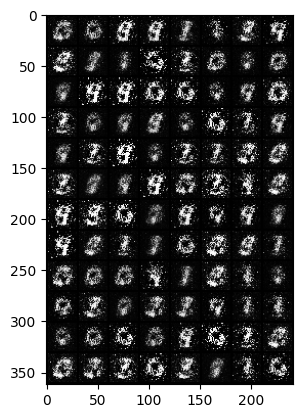

In [17]:
from skimage.io import imread
plt.imshow(imread('gan_images/1.png'))

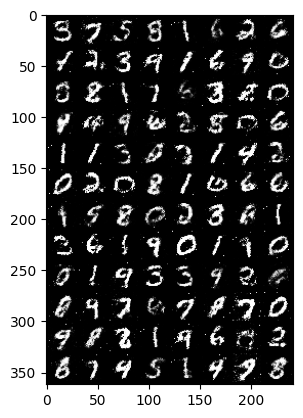

In [18]:
plt.imshow(imread('gan_images/10.png'))

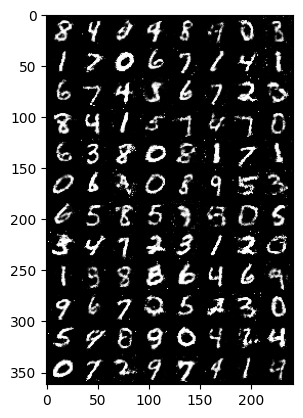

In [19]:
plt.imshow(imread('gan_images/25.png'))

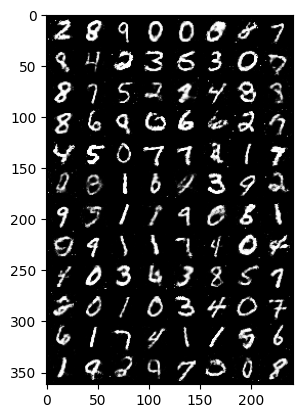

In [20]:
plt.imshow(imread('gan_images/50.png'))

# New Section